In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy.ma as ma

import gsw as sw
from mpl_toolkits.basemap import Basemap, cm, interp

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# import data

maxlon = 171
minlon = 130

Tok1 = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tokyo1_vSept16.csv', sep = ',')
Tok1['density'] = sw.rho(Tok1['S'].values,Tok1['T'].values,0)-1000
Tok1 = Tok1[(Tok1['Lon']>minlon) & (Tok1['Lon']<maxlon)]

Tok1['dlat'] = np.insert(np.diff(Tok1['Lat']), 0, 0)
Tok1 = Tok1[np.abs(Tok1['dlat'])<0.08]

Tok2 = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tokyo2_vSept16.csv', sep = ',')
Tok2['density'] = sw.rho(Tok2['S'].values,Tok2['T'].values,0)-1000

Tok3 = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tokyo3_vSept16.csv', sep = ',')
Tok3['density'] = sw.rho(Tok3['S'].values,Tok3['T'].values,0)-1000
Tok3 = Tok3[(Tok3['Lon']>minlon) & (Tok3['Lon']<maxlon)]

Tian = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tianjin2_vSept16.csv', sep = ',')
Tian['density'] = sw.rho(Tian['S'].values,Tian['T'].values,0)-1000
Tian = Tian[(Tian['Lon']>minlon) & (Tian['Lon']<maxlon)]

print Tian.columns

Index([u'Timestamp', u'Lat', u'Lon', u'S', u'T', u'Fluo', u'TrueO2Ar',
       u'O2Arsat', u'O2Arbiosat', u'MLD (WOA13)', u'Wkn', u'Air-sea flux',
       u'density'],
      dtype='object')


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


estimated calibration slope =  0.646943498049 , r =  0.809240679627 , p-value < 0.05  True


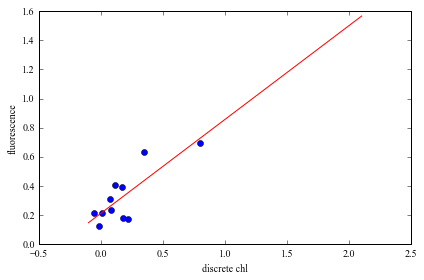

In [3]:
# import calibration data

calib = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Discrete_ChlO2Ar_ForSophie.csv', sep = ',')

calib = calib.dropna()
#calib = calib[(calib['Lon']>minlon) & (calib['Lon']<maxlon)]

subTok1 = calib[calib['Cruise ID']=='Tokyo_1']
subTok1['Fluo'] = np.interp(subTok1['Date/Time'],Tok1['Timestamp'], Tok1['Fluo'],left=np.nan, right=np.nan, period=None)
subTok1 = subTok1.dropna()

plt.plot(subTok1['Fluo'],subTok1['[Chl] (ug/L)'], 'o')
plt.xlabel('discrete chl')
plt.ylabel('fluorescence')

mT,cT, rT, pT, std_errT = ss.linregress(subTok1['Fluo'],subTok1['[Chl] (ug/L)'])
plt.plot(np.arange(-0.1, 2.2, 0.1), mT*(np.arange(-0.1, 2.2, 0.1))+cT, 'r')

print 'estimated calibration slope = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05

plt.show()

# calibrate fluorescence for Tokyo_1

Tok1['chl'] = mT*Tok1['Fluo']+cT

estimated calibration slope =  -72.4725371974 , r =  -0.0508311264577 , p-value < 0.05  False


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


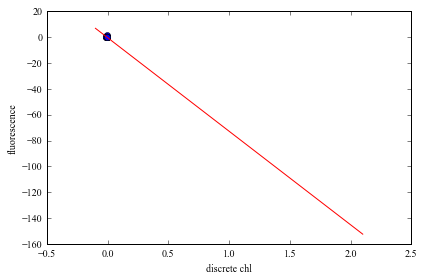

In [4]:
subTok2 = calib[calib['Cruise ID']=='Tokyo_2']
subTok2['Fluo'] = np.interp(subTok2['Date/Time'],Tok2['Timestamp'], Tok2['Fluo'],left=np.nan, right=np.nan, period=None)
subTok2 = subTok2.dropna()

plt.plot(subTok2['Fluo'],subTok2['[Chl] (ug/L)'], 'o')
plt.xlabel('discrete chl')
plt.ylabel('fluorescence')

mT,cT, rT, pT, std_errT = ss.linregress(subTok2['Fluo'],subTok2['[Chl] (ug/L)'])
plt.plot(np.arange(-0.1, 2.2, 0.1), mT*(np.arange(-0.1, 2.2, 0.1))+cT, 'r')

print 'estimated calibration slope = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05

plt.show()

# calibrate fluorescence for Tokyo_1

Tok2['chl'] = mT*Tok2['Fluo']+cT

estimated calibration slope =  0.254173244581 , r =  0.746429220644 , p-value < 0.05  True


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


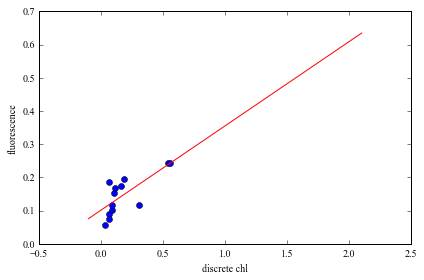

In [5]:
# import calibration data
subTok3 = calib[calib['Cruise ID']=='Tokyo_3']
subTok3['Fluo'] = np.interp(subTok3['Date/Time'],Tok3['Timestamp'], Tok3['Fluo'],left=np.nan, right=np.nan, period=None)
subTok3 = subTok3.dropna()

plt.plot(subTok3['Fluo'], subTok3['[Chl] (ug/L)'], 'o')
plt.xlabel('discrete chl')
plt.ylabel('fluorescence')

mT,cT, rT, pT, std_errT = ss.linregress(subTok3['Fluo'], subTok3['[Chl] (ug/L)'])
plt.plot(np.arange(-0.1, 2.2, 0.1), mT*(np.arange(-0.1, 2.2,0.1))+cT, 'r')

print 'estimated calibration slope = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05

plt.show()

Tok3['chl'] = mT*Tok3['Fluo']+cT

estimated calibration slope =  0.503576898909 , r =  0.92078143778 , p-value < 0.05  True


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


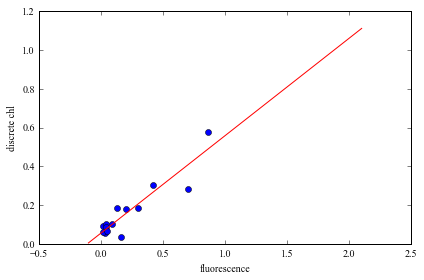

In [6]:
# import calibration data


subT = calib[calib['Cruise ID']=='Tianjin_2']
subT['Fluo'] = np.interp(subT['Date/Time'],Tian['Timestamp'], Tian['Fluo'], left=np.nan, right=np.nan, period=None)
subT = subT.dropna()

plt.plot(subT['Fluo'], subT['[Chl] (ug/L)'],'o')
plt.ylabel('discrete chl')
plt.xlabel('fluorescence')

mT,cT, rT, pT, std_errT = ss.linregress(subT['Fluo'], subT['[Chl] (ug/L)'])
plt.plot(np.arange(-0.1, 2.2, 0.1), mT*(np.arange(-0.1, 2.2, 0.1))+cT, 'r')

print 'estimated calibration slope = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05

plt.show()

Tian['chl'] = mT*Tian['Fluo']+cT

In [ ]:
# fig2, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (12, 18), dpi = 300)
fig2, (ax1, ax4) = plt.subplots(2, 1, figsize = (12, 12), dpi = 600)

nn = 4

ax1.plot(Tok1['Lon'], Tok1['chl'], '-k', lw = nn)
ax8 = ax1.twinx()
ax8.plot(Tok1['Lon'], Tok1['Air-sea flux'], '-r', lw = nn)
ax1.set_xlim([130, 170])
ax1.set_ylim([0, 1.6])
ax8.set_ylim([-10, 90])
ax1.text(134, 1.4,'May 2011', fontsize = 20)

ax1.set_ylabel('Chlorophyll (ug/L)', color='k', fontsize = 20)
ax8.set_ylabel('NCP (mmol O$_2$/m$^{2}$/day)', color= 'r', fontsize = 20)
ax8.tick_params(colors='r', labelsize = 20)
ax1.tick_params(colors='k', labelsize = 20)
ax1.axvline(146, color='grey', lw =3)

# ax2.plot(Tok2['Lon'], Tok2['chl'], '.k')
# ax5 = ax2.twinx()
# ax5.plot(Tok2['Lon'], Tok2['Air-sea flux'], '.r')
# ax2.set_xlim([130, 170])
# ax2.set_ylim([0, 1.75])
# ax5.set_ylim([-20, 80])
# ax2.text(132, 1.5,'July 2011', fontsize = 14)

# ax2.set_ylabel('Chlorophyll (ug/L)', color='k', fontsize = 14)
# ax5.set_ylabel('Net Community Production', color= 'r', fontsize = 14)
# ax5.tick_params(colors='r')

# ax3.plot(Tok3['Lon'], Tok3['chl'], '.k')
# ax6 = ax3.twinx()
# ax6.plot(Tok3['Lon'], Tok3['Air-sea flux'], '.r')
# ax3.set_xlim([130, 170])
# ax3.set_ylim([0, 1.75])
# ax6.set_ylim([-20, 80])
# ax3.text(132, 1.5,'September 2011', fontsize = 14)

# ax3.set_ylabel('Chlorophyll (ug/L)', color='k', fontsize = 14)
# ax6.set_ylabel('Net Community Production', color= 'r', fontsize = 14)
# ax6.tick_params(colors='r')

ax4.plot(Tian['Lon'], Tian['chl'], '-k', lw = nn)
ax7 = ax4.twinx()
ax7.plot(Tian['Lon'], Tian['Air-sea flux'], '-r', lw = nn)
ax4.set_xlim([130, 170])
ax4.set_ylim([0, 1.2])
ax7.set_ylim([-10, 60])
ax4.text(134, 1.0,'July 2012', fontsize = 20)

ax4.set_ylabel('Chlorophyll (ug/L)', color='k', fontsize = 20)
ax7.set_ylabel('NCP (mmol O$_2$/m$^{2}$/day)', color= 'r', fontsize = 20)
ax7.tick_params(colors='r', labelsize = 20)
ax4.tick_params(colors='k', labelsize = 20)
ax4.set_xlabel('Longitude', fontsize = 20)

ax7.axvline(153, color='grey', lw =3)
ax7.axvline(164, color='grey', lw =3)

plt.show()

#fig2.savefig('../figures/uway_NCP_Chl_MayJuly.png', dpi = 300)

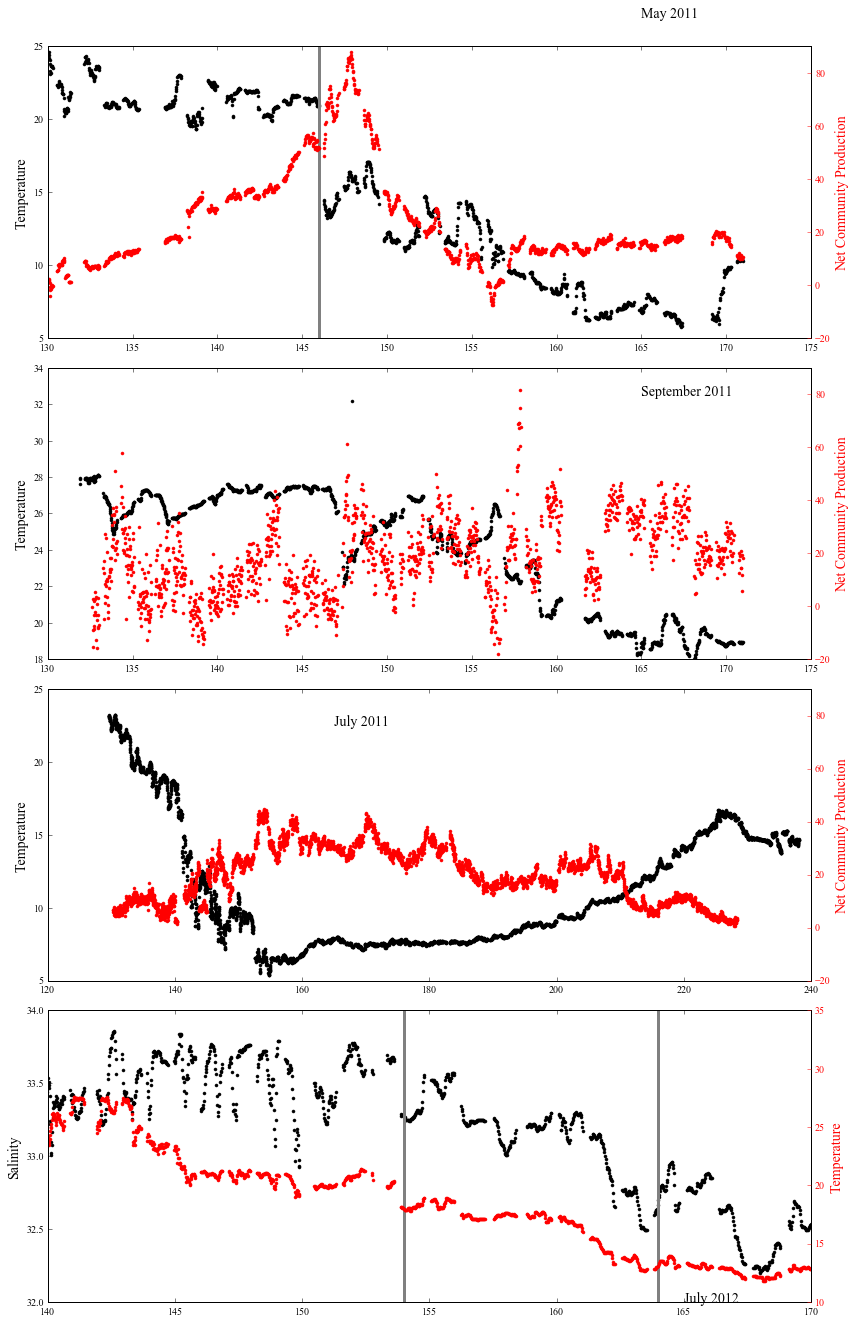

In [14]:
fig2, (ax1, ax2, ax3, ax7) = plt.subplots(4, 1, figsize = (12, 18), dpi = 300)

ax1.plot(Tok1['Lon'], Tok1['T'], '.k')
ax4 = ax1.twinx()
ax4.plot(Tok1['Lon'], Tok1['Air-sea flux'], '.r')
#ax1.set_xlim([140, 170])
#ax1.set_ylim([5, 25])
ax4.set_ylim([-20, 90])
ax1.text(165, 27,'May 2011', fontsize = 14)
ax1.axvline(146, color='grey', lw =3)
ax1.set_ylabel('Temperature', color='k', fontsize = 14)
ax4.set_ylabel('Net Community Production', color= 'r', fontsize = 14)
ax4.tick_params(colors='r')

ax2.plot(Tok3['Lon'], Tok3['T'], '.k')
ax5 = ax2.twinx()
ax5.plot(Tok3['Lon'], Tok3['Air-sea flux'], '.r')
#ax2.set_xlim([140, 170])
#ax2.set_ylim([15, 30])
ax5.set_ylim([-20, 90])
ax2.text(165, 32.5,'September 2011', fontsize = 14)

ax2.set_ylabel('Temperature', color='k', fontsize = 14)
ax5.set_ylabel('Net Community Production', color= 'r', fontsize = 14)
ax5.tick_params(colors='r')

ax3.plot(Tok2['Lon'], Tok2['T'], '.k')
ax6 = ax3.twinx()
ax6.plot(Tok2['Lon'], Tok2['Air-sea flux'], '.r')
#ax2.set_xlim([140, 170])
#ax2.set_ylim([15, 30])
ax6.set_ylim([-20, 90])
ax3.text(165, 22.5,'July 2011', fontsize = 14)

ax3.set_ylabel('Temperature', color='k', fontsize = 14)
ax6.set_ylabel('Net Community Production', color= 'r', fontsize = 14)
ax6.tick_params(colors='r')

ax7.plot(Tian['Lon'], Tian['S'], '.k')
ax7.set_xlim([140, 170])
ax8 = ax7.twinx()
ax8.plot(Tian['Lon'], Tian['T'], '.r')

ax7.set_ylim([32, 34])
#ax8.set_ylim([-20, 90])
ax7.text(165, 32,'July 2012', fontsize = 14)
# ax9 = ax7.twinx()
# ax9.plot(Tian['Lon'], Tian['chl'], '.g')
ax8.set_xlim([140, 170])
ax7.set_ylabel('Salinity', color='k', fontsize = 14)
ax8.set_ylabel('Temperature', color= 'r', fontsize = 14)
ax8.tick_params(colors='r')
ax8.set_xlabel('Longitude', fontsize = 14)
ax7.axvline(154, color='grey', lw =3)
ax7.axvline(164, color='grey', lw =3)


plt.show()

#fig2.savefig('../figures/uway_NCP_sst_MJJS.png', dpi = 300)

In [9]:
data = pd.concat([Tok1,  Tian], ignore_index = True)

subset = data 

# bin the nitrate data into sigma vs latitude bins

dy = 0.5
dx = 1.

ybin = np.arange(21., 27., dy)
xbin = np.arange(30., 45., dx)

xgrid, ygrid = np.meshgrid(xbin, ybin, sparse=False, indexing='ij')

binned = np.empty([len(xbin), len(ybin)])
binnedstd = np.empty([len(xbin), len(ybin)])
fvar = 'chl'

for i in range(len(xbin)):
    lat = xbin[i]
    for j in range(len(ybin)):
        sig = ybin[j]

        nn = len(subset.loc[((subset['Lat']>lat-dx/2) & (subset['Lat']<lat +dx/2) & (subset['density']>sig -dy/2)
                                        & (subset['density']<sig +dy/2)), fvar].values)

        if nn > 0:
            binned[i,j] = np.nanmean(subset.loc[((subset['Lat']>lat-dx/2) & (subset['Lat']<lat +dx/2) & (subset['density']>sig -dy/2)
                                        & (subset['density']<sig +dy/2)), fvar].values)
            binnedstd[i,j] = np.nanstd(subset.loc[((subset['Lat']>lat-dx/2) & (subset['Lat']<lat +dx/2) & (subset['density']>sig -dy/2)
                                        & (subset['density']<sig +dy/2)), fvar].values)
        else:
            binned[i,j] = np.nan
            binnedstd[i,j] = np.nan


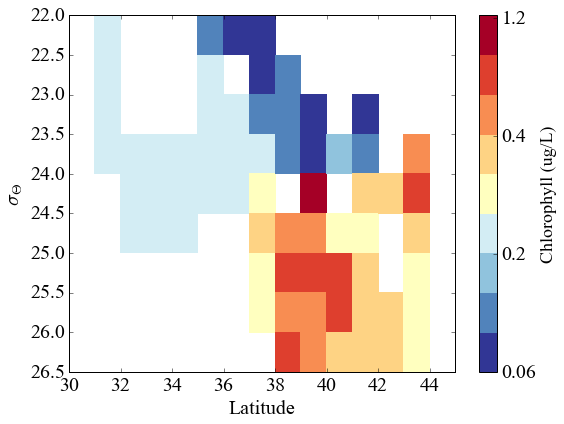

In [10]:
fig1 = plt.figure(1, figsize=(8,6))
#plt.scatter(subset['LAT'],subset['SIGMA_THETA[KG/M^3]'], c = subset['NITRATE[UMOL/KG]'], s=200, vmin = 0, vmax = 8, lw=0, alpha = 0.75)

palette = plt.get_cmap('RdYlBu_r',9)


binned = ma.masked_where(np.isnan(binned), binned)
binnedstd = ma.masked_where(np.isnan(binnedstd), binnedstd)

palette.set_bad('grey')

plt.pcolor(xgrid, ygrid, np.log10(binned), vmin = -1.2, vmax = 0.01, lw=0, cmap = palette)


#plt.contour()
cb = plt.colorbar(ticks = np.arange(-1.2, 0.01, 0.4))
cb.ax.set_yticklabels(['0.06','0.2','0.4','1.2'])
cb.set_label('Chlorophyll (ug/L)', fontsize = 18)
#plt.gca().invert_yaxis()
plt.axis([ 30,45, 26.5, 22.0])

#plt.axhline(23.5, color='grey', lw=2)
#plt.axhline(25, color='grey', lw=2) 

# plt.axvline(33., color='grey', lw=2)
# plt.axvline(38, color='grey', lw=2) 

plt.ylabel(r'$\sigma_{\Theta}$', fontsize = 20)
plt.xlabel('Latitude', fontsize = 20)
plt.tick_params(labelsize=20)
cb.ax.tick_params(labelsize=20)


plt.show()

#fig1.savefig('../figures/kuro_chl_binned_allcruises.png', bbox_inches='tight', dpi=600)

In [11]:
np.log10(np.min(binned))

-1.1984097240864771

In [12]:
np.arange(-1.2, 0.21, 0.4)


array([ -1.20000000e+00,  -8.00000000e-01,  -4.00000000e-01,
         2.22044605e-16])

In [13]:
10**0.1

1.2589254117941673

In [19]:
Tok1.corr()

,Timestamp,Lat,Lon,S,T,Fluo,TrueO2Ar,O2Arsat,O2Arbiosat,MLD (WOA13),Wkn,Air-sea flux,density,dlat,chl
Timestamp,1.000000,0.994943,0.999620,-0.589148,-0.935648,0.336171,-0.156779,0.936816,-0.189737,0.805015,0.104961,-0.140056,0.763654,-0.253183,0.336171
Lat,0.994943,1.000000,0.992229,-0.588679,-0.948421,0.380738,-0.147057,0.946108,-0.180453,0.777855,0.071250,-0.136767,0.783669,-0.225023,0.380738
Lon,0.999620,0.992229,1.000000,-0.592130,-0.933437,0.323054,-0.165718,0.936048,-0.198568,0.816558,0.109465,-0.148687,0.757558,-0.263135,0.323054
S,-0.589148,-0.588679,-0.592130,1.000000,0.551989,0.012425,0.183125,-0.605045,0.203671,-0.631653,-0.058839,0.169071,-0.062047,0.135086,0.012425
T,-0.935648,-0.948421,-0.933437,0.551989,1.000000,-0.366092,0.188537,-0.995393,0.223472,-0.785376,0.139806,0.232954,-0.861986,0.251068,-0.366092
Fluo,0.336171,0.380738,0.323054,0.012425,-0.366092,1.000000,0.041642,0.314549,0.029603,-0.025571,-0.129953,0.010687,0.493581,0.030157,1.000000
TrueO2Ar,-0.156779,-0.147057,-0.165718,0.183125,0.188537,0.041642,1.000000,-0.225594,0.999358,-0.447210,-0.349036,0.970885,-0.070914,0.232750,0.041642
O2Arsat,0.936816,0.946108,0.936048,-0.605045,-0.995393,0.314549,-0.225594,1.000000,-0.260360,0.826612,-0.113515,-0.263239,0.817822,-0.263404,0.314549
O2Arbiosat,-0.189737,-0.180453,-0.198568,0.203671,0.223472,0.029603,0.999358,-0.260360,1.000000,-0.473289,-0.341512,0.971962,-0.100418,0.240380,0.029603
MLD (WOA13),0.805015,0.777855,0.816558,-0.631653,-0.785376,-0.025571,-0.447210,0.826612,-0.473289,1.000000,0.127784,-0.446620,0.514996,-0.352911,-0.025571
